2025-01-28 09:55:27,242 - INFO - Loading datasets.
2025-01-28 09:55:27,262 - INFO - Engineering features.
2025-01-28 09:55:27,271 - INFO - Preprocessing features: Standardizing numeric columns and removing ID column.
2025-01-28 09:55:27,273 - INFO - Running K-Means clustering.
2025-01-28 09:55:27,321 - INFO - Optimal number of clusters for K-Means: 4
2025-01-28 09:55:27,330 - INFO - Running DBSCAN clustering.
2025-01-28 09:55:27,332 - INFO - Optimal epsilon for DBSCAN found: 0.4712443689813805
2025-01-28 09:55:27,334 - INFO - Running Agglomerative Clustering.
2025-01-28 09:55:27,406 - INFO - Best parameters for Agglomerative Clustering: {'linkage': 'average', 'n_clusters': 2}
2025-01-28 09:55:27,408 - INFO - Running Gaussian Mixture Model.
2025-01-28 09:55:27,497 - INFO - Optimal number of components for GMM: 10
2025-01-28 09:55:27,508 - INFO - K-Means - Number of Clusters: 4, Silhouette Score: 0.3991, Davies-Bouldin Index: 0.8001
2025-01-28 09:55:27,511 - INFO - DBSCAN - Number of Clu

K-Means - Number of Clusters: 4, Silhouette Score: 0.3991, Davies-Bouldin Index: 0.8001
DBSCAN - Number of Clusters: 2, Silhouette Score: 0.3824, Davies-Bouldin Index: 1.0167
Agglomerative - Number of Clusters: 2, Silhouette Score: 0.5915, Davies-Bouldin Index: 0.2580
GMM - Number of Clusters: 10, Silhouette Score: 0.3006, Davies-Bouldin Index: 1.0338


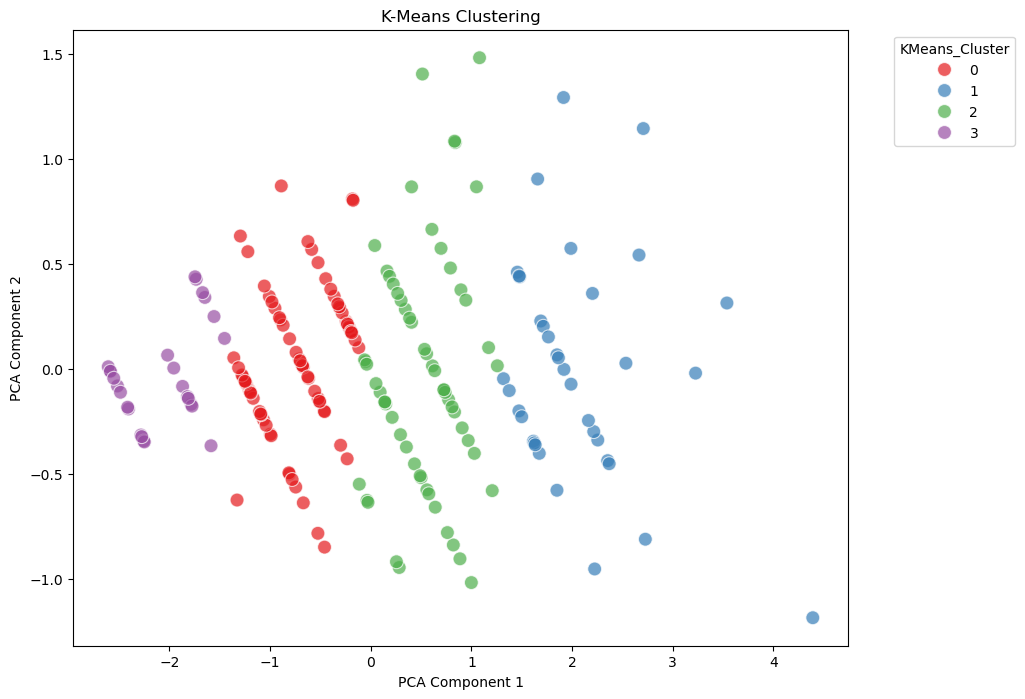

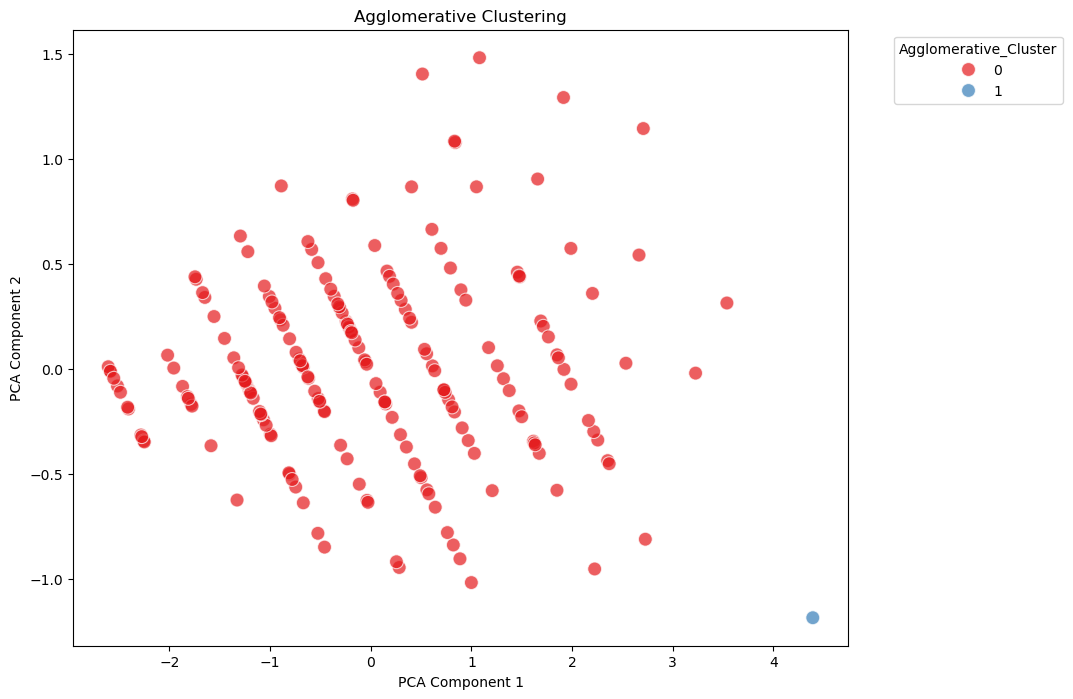

2025-01-28 09:55:27,778 - INFO - Saving clustering results.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --------------------------
# Utility Functions

def preprocess_features(df, id_column):
    """
    Standardizes numeric features and drops the ID column.
    """
    logging.info("Preprocessing features: Standardizing numeric columns and removing ID column.")
    features = df.drop(columns=[id_column])
    numeric_features = features.select_dtypes(include=['float64', 'int64'])
    scaled_features = StandardScaler().fit_transform(numeric_features)
    return scaled_features

def find_elbow_point(data, n_neighbors=5):
    """
    Finds the elbow point for DBSCAN using k-Nearest Neighbors.
    """
    neighbors = NearestNeighbors(n_neighbors=n_neighbors)
    neighbors.fit(data)
    distances, _ = neighbors.kneighbors(data)
    distances = np.sort(distances[:, -1])
    elbow = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing").knee_y
    logging.info(f"Optimal epsilon for DBSCAN found: {elbow}")
    return elbow

def evaluate_clusters(data, clusters, method_name):
    """
    Evaluates clustering performance using silhouette and Davies-Bouldin scores.
    """
    n_clusters = len(np.unique(clusters))
    if n_clusters > 1:
        silhouette = silhouette_score(data, clusters)
        db_score = davies_bouldin_score(data, clusters)
        logging.info(f"{method_name} - Number of Clusters: {n_clusters}, Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {db_score:.4f}")
        print(f"{method_name} - Number of Clusters: {n_clusters}, Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {db_score:.4f}")
        return silhouette, db_score
    else:
        logging.warning(f"{method_name} found only 1 cluster. Skipping evaluation.")
        print(f"{method_name} found only 1 cluster. Skipping evaluation.")
        return None, None

def visualize_clusters(data, pca_components, cluster_column, title):
    """
    Visualizes clusters using PCA-reduced components.
    """
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=pca_components[:, 0], y=pca_components[:, 1],
        hue=data[cluster_column], palette='Set1', s=100, alpha=0.7
    )
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title=cluster_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# --------------------------
# Clustering Algorithms

def run_kmeans(data, max_clusters=10):
    """Runs K-Means clustering and determines the optimal number of clusters using the elbow method."""
    logging.info("Running K-Means clustering.")
    inertia = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    optimal_k = KneeLocator(range(2, max_clusters + 1), inertia, curve="convex", direction="decreasing").knee
    logging.info(f"Optimal number of clusters for K-Means: {optimal_k}")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++', n_init=10)
    clusters = kmeans.fit_predict(data)
    return clusters, optimal_k

def run_dbscan(data):
    """Runs DBSCAN clustering with optimal epsilon determined by k-nearest neighbors."""
    logging.info("Running DBSCAN clustering.")
    epsilon = find_elbow_point(data)
    dbscan = DBSCAN(eps=epsilon, min_samples=10)
    clusters = dbscan.fit_predict(data)
    return clusters

def run_agglomerative(data, max_clusters=10):
    """Runs Agglomerative Clustering with the best linkage method based on silhouette score."""
    logging.info("Running Agglomerative Clustering.")
    best_score = -1
    best_params = {}
    for linkage in ['ward', 'complete', 'average', 'single']:
        for k in range(2, max_clusters + 1):
            agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            clusters = agg.fit_predict(data)
            score = silhouette_score(data, clusters)
            if score > best_score:
                best_score = score
                best_params = {"linkage": linkage, "n_clusters": k}
    logging.info(f"Best parameters for Agglomerative Clustering: {best_params}")
    agg = AgglomerativeClustering(**best_params)
    clusters = agg.fit_predict(data)
    return clusters, best_params

def run_gmm(data, max_components=10):
    """Runs Gaussian Mixture Models and determines the optimal number of components using BIC."""
    logging.info("Running Gaussian Mixture Model.")
    lowest_bic = np.inf
    best_components = None
    for n_components in range(2, max_components + 1):
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(data)
        bic = gmm.bic(data)
        if bic < lowest_bic:
            lowest_bic = bic
            best_components = n_components
    logging.info(f"Optimal number of components for GMM: {best_components}")
    gmm = GaussianMixture(n_components=best_components, covariance_type='full', random_state=42)
    clusters = gmm.fit_predict(data)
    return clusters

# --------------------------
# Main Execution

if __name__ == "__main__":
    # Load datasets
    logging.info("Loading datasets.")
    customers_df = pd.read_csv('Customers.csv')
    transactions_df = pd.read_csv('Transactions.csv')

    # Feature Engineering
    logging.info("Engineering features.")
    customer_transactions = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': 'max',
        'TotalValue': 'sum',
        'TransactionID': 'count'
    }).reset_index()

    features = pd.merge(customers_df, customer_transactions, on='CustomerID')

    # Preprocessing
    scaled_features = preprocess_features(features, id_column='CustomerID')

    # Run clustering methods
    features['KMeans_Cluster'], optimal_k = run_kmeans(scaled_features)
    features['DBSCAN_Cluster'] = run_dbscan(scaled_features)
    features['Agglomerative_Cluster'], agg_params = run_agglomerative(scaled_features)
    features['GMM_Cluster'] = run_gmm(scaled_features)

    # Evaluate clustering methods
    evaluate_clusters(scaled_features, features['KMeans_Cluster'], "K-Means")
    evaluate_clusters(scaled_features, features['DBSCAN_Cluster'], "DBSCAN")
    evaluate_clusters(scaled_features, features['Agglomerative_Cluster'], "Agglomerative")
    evaluate_clusters(scaled_features, features['GMM_Cluster'], "GMM")

    # PCA visualization
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(scaled_features)
    visualize_clusters(features, pca_components, 'KMeans_Cluster', 'K-Means Clustering')
    visualize_clusters(features, pca_components, 'Agglomerative_Cluster', 'Agglomerative Clustering')

    # Save results
    logging.info("Saving clustering results.")
    features[['CustomerID', 'KMeans_Cluster', 'DBSCAN_Cluster', 'Agglomerative_Cluster', 'GMM_Cluster']].to_csv(
        'Customer_Segmentation_Clusters.csv', index=False
    )
